In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.manual_seed(100)
batch_size = 100

In [3]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 220816175.97it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57437503.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66908124.65it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18824633.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
val_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - val_size

In [5]:
val_dataset, test_dataset = train_test_split(test_dataset, train_size=val_size, test_size=test_size)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

60000
5000
5000


In [8]:
print(train_dataset[0][0].size())
print(train_dataset[0][0].numpy().shape)
print(train_dataset[0][1])

torch.Size([1, 28, 28])
(1, 28, 28)
5


Label: 0


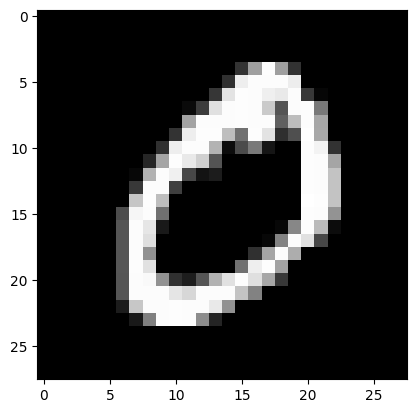

In [9]:
print("Label:", train_dataset[1][1])
show_img = train_dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [10]:
num_iters = 8000
input_dim = 28*28 
num_hidden = 100
output_dim = 10

learning_rate = 0.1
num_epochs = int(num_iters / (len(train_dataset) / batch_size))
print(num_epochs)

13


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        probas  = self.linear_out(out)
        return probas

In [13]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch+1}/{num_epochs}, loss: {avg_train_loss:.4f}, accuracy: {train_accuracy:.2%}, val_loss: {avg_val_loss:.4f}, val_accuracy: {val_accuracy:.2%}')


Epoch 1/13, loss: 0.8138, accuracy: 75.82%, val_loss: 0.2723, val_accuracy: 91.80%
Epoch 2/13, loss: 0.2264, accuracy: 93.24%, val_loss: 0.1719, val_accuracy: 94.78%
Epoch 3/13, loss: 0.1472, accuracy: 95.64%, val_loss: 0.1315, val_accuracy: 95.90%
Epoch 4/13, loss: 0.1148, accuracy: 96.53%, val_loss: 0.1255, val_accuracy: 96.08%
Epoch 5/13, loss: 0.0941, accuracy: 97.19%, val_loss: 0.1005, val_accuracy: 97.14%
Epoch 6/13, loss: 0.0775, accuracy: 97.69%, val_loss: 0.0863, val_accuracy: 97.22%
Epoch 7/13, loss: 0.0673, accuracy: 97.94%, val_loss: 0.0842, val_accuracy: 97.42%
Epoch 8/13, loss: 0.0588, accuracy: 98.19%, val_loss: 0.0820, val_accuracy: 97.54%
Epoch 9/13, loss: 0.0514, accuracy: 98.41%, val_loss: 0.0928, val_accuracy: 97.18%
Epoch 10/13, loss: 0.0450, accuracy: 98.65%, val_loss: 0.0803, val_accuracy: 97.68%
Epoch 11/13, loss: 0.0386, accuracy: 98.81%, val_loss: 0.0818, val_accuracy: 97.28%
Epoch 12/13, loss: 0.0344, accuracy: 98.98%, val_loss: 0.0835, val_accuracy: 97.48%
E

In [16]:
model.eval()
correct_test = 0
total_test = 0
predictions_test = []
targets_test = []

with torch.no_grad():
    for images, labels in test_loader:
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        predictions_test.extend(predicted.cpu().numpy())
        targets_test.extend(labels.cpu().numpy())

test_accuracy = correct_test / total_test


precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(targets_test, predictions_test, average='weighted')

print('Accuracy: {:.2%}'.format(test_accuracy))
print(f'Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-score: {f1_test:.4f}')

Accuracy: 97.78%
Precision: 0.9780, Recall: 0.9778, F1-score: 0.9778


# **Explanation**

To configure and train the network, i have made several choices in terms of architecture, hyperparameters, and optimization. Let's break down the configuration and training choices i've made:

**Network Architecture:**
1. Model Class (DeepNeuralNetworkModel):

    * Layers: Three hidden layers with ReLU activation and an output layer.
    * Activation Function: ReLU (Rectified Linear Unit) is used as the activation function for hidden layers. ReLU is a commonly used activation function that introduces non-linearity to the model.
2. Input and Output:

    * Input Dimension (input_dim): 28 * 28 = 784, i have been working with flattened MNIST images.
    * Output Dimension (output_dim): 10, corresponding to the number of classes in MNIST (digits 0-9).
**Hyperparameters:**
1. Number of Hidden Units (num_hidden):

    * Choice: 100 hidden units in each hidden layer.
    * Reasoning: The number of hidden units is often chosen based on experimentation. It's not too large to risk overfitting and not too small to risk underfitting.
2. Learning Rate (learning_rate):

    * Choice: 0.1
    * Reasoning: The learning rate determines the step size during gradient descent. A value of 0.1 is a common starting point, and it seems reasonable for your task. However, optimal learning rates often require experimentation.
**Training:**
1. Number of Training Iterations (num_iters):

    * Choice: 8000 iterations.
    * Reasoning: The number of iterations is a hyperparameter. It's chosen based on experimentation and is often related to the size of the dataset and the batch size. In this case, it's determined by the number of epochs and batch size.
2. Batch Size:

    * Choice: 100
    * Reasoning: Batch size affects the efficiency of training and can impact model generalization.
3. Loss Function (criterion):

    * Choice: CrossEntropyLoss
    * Reasoning: CrossEntropyLoss is a suitable choice for multi-class classification problems. It combines softmax activation and log-likelihood loss, making it appropriate for the final layer of my network.
4. Optimizer (optimizer):

    * Choice: SGD (Stochastic Gradient Descent)
    * Reasoning: SGD is a basic optimizer commonly used for training neural networks. It's a good starting point for experimentation, though more advanced optimizers like Adam are also popular.
**Training Loop:**
1. Training Loop Structure:

    * Training and Validation:
    I've structured the training loop to include both training and validation phases, which is a good practice for monitoring model performance.
2. Evaluation Metrics:

    * Accuracy, Precision, Recall, F1-score:
    I have used these metrics to evaluate the model's performance comprehensively.